In [69]:
import cv2
import numpy as np
import os.path as osp
import os
import copy
import random
from datetime import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms as T
import seaborn as sns


In [70]:
## Input : RGB(3-channel) + Point_Cloud(3-channel)

model_path = 'model_dir'
data_path = '/mnt/nas3/yrkim/liveness_lidar_project/GC_project/LDFAS'

# person_number = [int(i) for i in os.listdir(data_path) if i.isdigit()]
person_number = [i for i in range(1,13)]
test_number = [i for i in range(13,16)]

traindata_portion = 0.8

train_img_paths, test_img_paths = [],[]
for i in person_number :
    img_path = osp.join(data_path,str(i),'bonafide')
    files = os.listdir(img_path)
    files = [j for j in files if (j.split('.')[-1]=='jpg') and (j.split('_')[0]=='rgb')]
    random.shuffle(files)
    
    mask_files= [osp.join(data_path,str(i),'attack_mask',j) for j in files]
    replay_files= [osp.join(data_path,str(i),'attack_replay',j) for j in files]
    paper_files= [osp.join(data_path,str(i),'attack_paper',j) for j in files]
    files = [osp.join(data_path,str(i),'bonafide',j) for j in files]
    
    cloud_files = [osp.join('real_cloud_data',j.split('/')[-3], 
                            (('pc_'+j.split('/')[-1].split('_')[-1]).split('.')[0]+'.npy')) for j in files]
    mask_cloud_files = [osp.join('mask_cloud_data',j.split('/')[-3], 
                            (('pc_'+j.split('/')[-1].split('_')[-1]).split('.')[0]+'.npy')) for j in mask_files]
    replay_cloud_files = [osp.join('replay_cloud_data',j.split('/')[-3], 
                            (('pc_'+j.split('/')[-1].split('_')[-1]).split('.')[0]+'.npy')) for j in replay_files]
    paper_cloud_files = [osp.join('paper_cloud_data',j.split('/')[-3], 
                            (('pc_'+j.split('/')[-1].split('_')[-1]).split('.')[0]+'.npy')) for j in paper_files]
        
    train_img_paths += list(zip(files,cloud_files))[:int(len(files)*traindata_portion)]
    train_img_paths += list(zip(mask_files,mask_cloud_files))[:int(len(files)*traindata_portion)]
    train_img_paths += list(zip(replay_files,replay_cloud_files))[:int(len(files)*traindata_portion)]
    train_img_paths += list(zip(paper_files,paper_cloud_files))[:int(len(files)*traindata_portion)]
    
    test_img_paths += list(zip(files,cloud_files))[int(len(files)*traindata_portion):]
#     test_img_paths += list(zip(mask_files,mask_cloud_files))[int(len(files)*traindata_portion):]
#     test_img_paths += list(zip(replay_files,replay_cloud_files))[int(len(files)*traindata_portion):]
    test_img_paths += list(zip(paper_files,paper_cloud_files))[int(len(files)*traindata_portion):]

    
for i in test_number :
    img_path = osp.join(data_path,str(i),'bonafide')
    files = os.listdir(img_path)
    files = [j for j in files if (j.split('.')[-1]=='jpg') and (j.split('_')[0]=='rgb')]
    random.shuffle(files)
    
#     mask_files= [osp.join(data_path,str(i),'attack_mask',j) for j in files]
#     replay_files= [osp.join(data_path,str(i),'attack_replay',j) for j in files]
    paper_files= [osp.join(data_path,str(i),'attack_paper',j) for j in files]
    files = [osp.join(data_path,str(i),'bonafide',j) for j in files]
    
    cloud_files = [osp.join('real_cloud_data',j.split('/')[-3], 
                            (('pc_'+j.split('/')[-1].split('_')[-1]).split('.')[0]+'.npy')) for j in files]
#     mask_cloud_files = [osp.join('mask_cloud_data',j.split('/')[-3], 
#                             (('pc_'+j.split('/')[-1].split('_')[-1]).split('.')[0]+'.npy')) for j in mask_files]
#     replay_cloud_files = [osp.join('replay_cloud_data',j.split('/')[-3], 
#                             (('pc_'+j.split('/')[-1].split('_')[-1]).split('.')[0]+'.npy')) for j in replay_files]
    paper_cloud_files = [osp.join('paper_cloud_data',j.split('/')[-3], 
                            (('pc_'+j.split('/')[-1].split('_')[-1]).split('.')[0]+'.npy')) for j in paper_files]
        
    test_img_paths += list(zip(files,cloud_files))[:]
#     test_img_paths += list(zip(mask_files,mask_cloud_files))[:]
#     test_img_paths += list(zip(replay_files,replay_cloud_files))[:]
    test_img_paths += list(zip(paper_files,paper_cloud_files))[:]


random.shuffle(train_img_paths)
random.shuffle(test_img_paths)

print(len(train_img_paths))
print(len(test_img_paths))

768
216


In [71]:
class FaceData(Dataset):
    def __init__(self,data_paths) :
        self.data_paths = data_paths
        
        normalize = T.Normalize(mean=[0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225])
        self.transforms = T.Compose([
            T.ToTensor(),
            normalize
        ])
        
    def __getitem__(self, index):
        rgb_path = self.data_paths[index][0]
        cloud_path = self.data_paths[index][1]
        data = cv2.imread(rgb_path)
        data = cv2.cvtColor(data, cv2.COLOR_BGR2RGB)
        # point-cloud data shape : (256, 192, 3)
        data = cv2.resize(data, (180,180), interpolation=cv2.INTER_CUBIC)
        
        print(f"rgb data shape {data.shape}")
        # crop
        crop_width = 90
        crop_height = 140
        mid_x, mid_y = 90, 90
        offset_x, offset_y = crop_width//2, crop_height//2
        data = data[mid_y-offset_y:mid_y+offset_y, mid_x-offset_x:mid_x+offset_x]
        print(f"cropped rgb data shape {data.shape}")
        
        
        if self.transforms is not None :
            data = self.transforms(data)
            
        cloud_data = np.load(cloud_path)
        cloud_data = cv2.resize(cloud_data, (180,180), interpolation=cv2.INTER_CUBIC)
        cloud_data += 5
        print(f"cloud data shape {cloud_data.shape}")
        ###### [!!!]  If A data is not scaled, it causes low performance.
        shift_value = 0
        xcoor = np.array(cloud_data[:, :, 0] + shift_value)
        ycoor = np.array(cloud_data[:, :, 1] + shift_value)
        zcoor = np.array(cloud_data[:, :, 2] + shift_value)
        
        xcoor = (xcoor-xcoor.mean())/xcoor.std()
        ycoor = (ycoor-ycoor.mean())/ycoor.std()
        zcoor = (zcoor-zcoor.mean())/zcoor.std()
        
        scaled_cloud = np.concatenate([xcoor[np.newaxis,:],ycoor[np.newaxis,:],zcoor[np.newaxis,:]])
        
        ######
        
        
        # label - { 0 : real , 1 : mask }
        if 'bonafide' in rgb_path :
            label = 0
        elif 'attack_mask' in rgb_path :
            label = 1
        elif 'attack_replay' in rgb_path :
            label = 1
        elif 'attack_paper' in rgb_path :
            label = 1
        return data,cloud_data,scaled_cloud, label
    
    def __len__(self):
        return len(self.data_paths)

768 216


  0%|          | 0/192 [00:00<?, ?it/s]

rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)
cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)



cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)


rgb data shape (180, 180, 3)
cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)
cropped rgb data shape (140, 90, 3)

cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)

rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)


cropped rgb data shape (140, 90, 3)cropped r

  1%|          | 1/192 [00:01<06:14,  1.96s/it]


cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)
cropped rgb data shape (140, 90, 3)


cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)

rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)

cropped rgb data shape (140, 90, 3)
cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)

cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)

cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)

rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)

cloud data shape (180, 180, 4)
cropped rgb data shape (140, 90, 3)
cropped rgb data shape (140, 90, 3)

cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)
rgb d

  3%|▎         | 5/192 [00:02<01:21,  2.30it/s]


rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)

cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)

cloud data shape (180, 180, 4)
cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)

cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)

cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)
cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)

cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)



cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)

cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)clou

  5%|▍         | 9/192 [00:03<00:45,  4.02it/s]

rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)

cropped rgb data shape (140, 90, 3)
cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)

cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)

cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)

rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)

cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)
cropped rgb data shape (140, 90, 3)
cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)

cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)

rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)


cloud data sh

  7%|▋         | 13/192 [00:03<00:30,  5.87it/s]

cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)


cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)


cloud data shape (180, 180, 4)
cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)

cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)

rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)

cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)

  7%|▋         | 14/192 [00:03<00:32,  5.55it/s]


cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)

cloud data shape (180, 180, 4)
cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)
cloud data shape (180, 180, 4)
cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)


cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)

rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)


rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)





  9%|▉         | 17/192 [00:04<00:29,  5.87it/s]

cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)

cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)
cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)

cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)

rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)

  9%|▉         | 18/192 [00:04<00:34,  4.98it/s]

rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)

cloud data shape (180, 180, 4)
cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)

cropped rgb data shape (140, 90, 3)

cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)


rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)

rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)
cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)

cloud data shape (180, 180, 4)

cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)

cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)



 11%|█         | 21/192 [00:04<00:34,  5.03it/s]

cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)

rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)

cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)

cropped rgb data shape (140, 90, 3)

cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)


rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)

cloud data shape (180, 180, 4)

cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)


 11%|█▏        | 22/192 [00:05<00:39,  4.32it/s]


cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)

cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)


cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)

cropped rgb data shape (140, 90, 3)

rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)



cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)


cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)

cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)


 13%|█▎        | 25/192 [00:05<00:34,  4.84it/s]

cloud data shape (180, 180, 4)

rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)
cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)

rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)

rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)

cropped rgb data shape (140, 90, 3)
cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)

cloud data shape (180, 180, 4)
cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)
cloud data shape (180, 180, 4)




 14%|█▎        | 26/192 [00:06<00:40,  4.06it/s]


cloud data shape (180, 180, 4)
cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)
cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)


cropped rgb data shape (140, 90, 3)

 14%|█▍        | 27/192 [00:06<00:37,  4.35it/s]


cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)

rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)

cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)



cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)
cloud data shape (180, 180, 4)
cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)




 15%|█▌        | 29/192 [00:06<00:33,  4.89it/s]

cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)

rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)


cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)


cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)


rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)
cropped rgb data shape (140, 90, 3)

rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)




 16%|█▌        | 30/192 [00:07<00:37,  4.26it/s]

cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)

cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)


cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)

cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)

 16%|█▌        | 31/192 [00:07<00:34,  4.60it/s]

rgb data shape (180, 180, 3)


cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)

cloud data shape (180, 180, 4)
cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)


rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)

rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)



 17%|█▋        | 33/192 [00:07<00:32,  4.87it/s]


cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)
cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)


cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)

cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)


 18%|█▊        | 34/192 [00:07<00:33,  4.69it/s]

cloud data shape (180, 180, 4)


cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)
cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)

cropped rgb data shape (140, 90, 3)


cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)


cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)



 18%|█▊        | 35/192 [00:08<00:39,  3.99it/s]


cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)

rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)


cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)

cloud data shape (180, 180, 4)
cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)

cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)


 19%|█▉        | 37/192 [00:08<00:32,  4.75it/s]

rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)


cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)


cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)

cloud data shape (180, 180, 4)
cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)


cropped rgb data shape (140, 90, 3)
cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)

rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)
cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)


 20%|█▉        | 38/192 [00:09<00:41,  3.72it/s]


cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)


rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)
cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)
cloud data shape (180, 180, 4)

cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)

rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)

cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)


cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)

 21%|██▏       | 41/192 [00:09<00:29,  5.17it/s]

cropped rgb data shape (140, 90, 3)

rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)

cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)

cropped rgb data shape (140, 90, 3)
cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)



cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)

rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)


cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)


rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)


cropped rgb data shape (140, 90, 3)

 22%|██▏       | 42/192 [00:10<00:41,  3.60it/s]


rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)
cropped rgb data shape (140, 90, 3)

rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)

cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)


cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)

rgb data shape (180, 180, 3)
cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)


 22%|██▏       | 43/192 [00:10<00:41,  3.61it/s]



cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)


cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)

cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)
cropped rgb data shape (140, 90, 3)



 23%|██▎       | 45/192 [00:10<00:30,  4.85it/s]


cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)

rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)
cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)


cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)

rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)
cropped rgb data shape (140, 90, 3)


cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)


rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)

rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)
cloud data s

 24%|██▍       | 46/192 [00:11<00:39,  3.66it/s]




cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)
cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)
cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)

cloud data shape (180, 180, 4)

cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)


cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)

cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)

cloud data shape (180, 180, 4)
cropped rgb data shape (140, 90, 3)

 26%|██▌       | 49/192 [00:11<00:27,  5.13it/s]

cloud data shape (180, 180, 4)

cloud data shape (180, 180, 4)

rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)
cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)

cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)


cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)


 26%|██▌       | 50/192 [00:11<00:29,  4.82it/s]

cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)


cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)

cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)

cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)


cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)



rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)

cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)
rgb data 

 28%|██▊       | 53/192 [00:12<00:26,  5.15it/s]

cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)

rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)



cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)

cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)



 28%|██▊       | 54/192 [00:12<00:27,  5.09it/s]

cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)
cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)


rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)

rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)
cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)


cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)

cropped rgb data shape (140, 90, 3)

rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)


cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)


cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)
rgb d

 30%|██▉       | 57/192 [00:12<00:25,  5.24it/s]


cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)

cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)

rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)

rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)
cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)

cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)



cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)

cloud data shape (180, 180, 4)

 30%|███       | 58/192 [00:13<00:32,  4.09it/s]

rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)
cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)


rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)
cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)

cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)


cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)

rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)

rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)
cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)

cloud data shape (180, 180, 4)

cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)

 32%|███▏      | 61/192 [00:13<00:28,  4.61it/s]



cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)


cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)
cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)


cropped rgb data shape (140, 90, 3)

 32%|███▏      | 62/192 [00:14<00:29,  4.42it/s]


cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)

rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)

cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)

rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)
cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)

cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)

rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)
cropped rgb data shape (140, 90, 3)

cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)

rgb data shape (180, 180, 3)
cloud data shape (180, 180, 4)
cropped rgb data shape (140, 90, 3)



 34%|███▍      | 65/192 [00:14<00:24,  5.13it/s]

cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)

cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)


cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)
cloud data shape (180, 180, 4)

cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)



 34%|███▍      | 66/192 [00:14<00:24,  5.18it/s]

rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)
cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)

cloud data shape (180, 180, 4)

cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)

rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)
cropped rgb data shape (140, 90, 3)
cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)


rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)

cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)



cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)

cloud 

 36%|███▌      | 69/192 [00:15<00:17,  6.96it/s]


rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)

rgb data shape (180, 180, 3)
cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)


cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)


cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)


cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)

rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)

cropped rgb 

 38%|███▊      | 73/192 [00:15<00:17,  6.95it/s]



cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)

cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)

rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)
cloud data shape (180, 180, 4)

cropped rgb data shape (140, 90, 3)
cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)
cloud data shape (180, 180, 4)

rgb data shape (180, 180, 3)

 39%|███▊      | 74/192 [00:15<00:19,  6.07it/s]

cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)


cloud data shape (180, 180, 4)
cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)


cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)

cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)


cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)

cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)


cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)

cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)

rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)
cropped r

 40%|████      | 77/192 [00:16<00:20,  5.73it/s]

rgb data shape (180, 180, 3)


cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)
cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)



cloud data shape (180, 180, 4)
cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)
cloud data shape (180, 180, 4)

cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)

rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)

cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)


 41%|████      | 78/192 [00:16<00:23,  4.91it/s]

cloud data shape (180, 180, 4)
cropped rgb data shape (140, 90, 3)

rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)

rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)


cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)


cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)
cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)



cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)

rgb data shape (180, 180, 3)


 42%|████▏     | 81/192 [00:17<00:22,  4.96it/s]


cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)
cloud data shape (180, 180, 4)

cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)
cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)


cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)

cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)


cropped rgb data shape (140, 90, 3)

cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)


rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)

cropped rgb data shape (140, 90, 3)
cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)
cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)



 43%|████▎     | 82/192 [00:18<00:29,  3.71it/s]


cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)

rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)

rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)


rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)

cropped rgb data shape (140, 90, 3)

cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)



 44%|████▍     | 85/192 [00:18<00:21,  4.89it/s]

rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)


cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)
cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)



cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)



rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)

rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)

cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)


cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)

cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)

cloud 

 45%|████▍     | 86/192 [00:19<00:27,  3.87it/s]



cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)
cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)
cropped rgb data shape (140, 90, 3)

cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)

cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)


 46%|████▋     | 89/192 [00:19<00:19,  5.23it/s]

cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)
cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)


rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)
cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)

cropped rgb data shape (140, 90, 3)

rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)


rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)



cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)
cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)


cropped rgb data shape (140, 90, 3)

 47%|████▋     | 90/192 [00:19<00:26,  3.82it/s]

cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)
cloud data shape (180, 180, 4)

cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)


rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)
cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)

rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)




 48%|████▊     | 93/192 [00:20<00:20,  4.77it/s]

cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)


cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)

rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)
cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)


cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)

cropped rgb data shape (140, 90, 3)

rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)
cropped rgb data shape (140, 90, 3)

rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)
cloud data shape (180, 180, 4)

cropped rgb data shape (140, 90, 3)

cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)

 49%|████▉     | 94/192 [00:20<00:28,  3.50it/s]



cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)



cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)
cropped rgb data shape (140, 90, 3)

cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)

rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)

cropped rgb data shape (140, 90, 3)
cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)

 51%|█████     | 97/192 [00:21<00:22,  4.15it/s]




rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)

rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)
cropped rgb data shape (140, 90, 3)


cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)

cloud data shape (180, 180, 4)

rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)

cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)
cloud data shape (180, 180, 4)




 51%|█████     | 98/192 [00:22<00:28,  3.32it/s]

cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)

cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)

cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)


cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)


cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)


cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)
cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)

cropped rgb data shape (140, 90, 3)


 53%|█████▎    | 101/192 [00:22<00:23,  3.88it/s]



cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)
cloud data shape (180, 180, 4)

rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)
cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)

rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)

cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)

rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)
cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)
cropped rgb data shape (140, 90, 3)


cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)

 53%|█████▎    | 102/192 [00:23<00:26,  3.42it/s]



rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)


cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)


cloud data shape (180, 180, 4)

cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)

rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)


cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)
cloud data shape (180, 180, 4)
cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)
cropped rgb data shape (140, 90, 3)

cloud data shape (180, 180, 4)

cloud data shape (180, 180, 4)


 55%|█████▍    | 105/192 [00:23<00:20,  4.20it/s]

rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)


cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)



cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)


cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)


cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)

cropped rgb data shape (140, 90, 3)

 55%|█████▌    | 106/192 [00:23<00:20,  4.28it/s]

rgb data shape (180, 180, 3)
cloud data shape (180, 180, 4)

cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)

cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)


rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)
cropped rgb data shape (140, 90, 3)

cloud data shape (180, 180, 4)
cropped rgb data shape (140, 90, 3)

cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)


cloud data shape (180, 180, 4)
cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)

rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)
cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)


cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)
cloud data shape (180, 180, 4)


 57%|█████▋    | 109/192 [00:24<00:16,  5.04it/s]


rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)
cloud data shape (180, 180, 4)
cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)



cloud data shape (180, 180, 4)
cropped rgb data shape (140, 90, 3)
cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)

rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)

rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)

cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)

rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)
cropped rgb data shape (140, 90, 3)



 57%|█████▋    | 110/192 [00:24<00:18,  4.38it/s]

cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)



cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)


rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)

rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)
cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)



 59%|█████▉    | 113/192 [00:25<00:16,  4.76it/s]



cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)


cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)
cropped rgb data shape (140, 90, 3)

cropped rgb data shape (140, 90, 3)

cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)

 59%|█████▉    | 114/192 [00:25<00:18,  4.16it/s]


rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)

cloud data shape (180, 180, 4)

cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)

rgb data shape (180, 180, 3)
cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)

cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)


cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)

cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)

cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)



 61%|██████    | 117/192 [00:26<00:16,  4.65it/s]


cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)

cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)

rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)

rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)


cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)


cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)

rgb data shape (180, 180, 3)

 61%|██████▏   | 118/192 [00:26<00:17,  4.15it/s]

cropped rgb data shape (140, 90, 3)


cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)

cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)

rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)

cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)

cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)
cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)

rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)


cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)

cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)


 63%|██████▎   | 121/192 [00:27<00:15,  4.62it/s]



cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)
cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)

rgb data shape (180, 180, 3)
cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)

cropped rgb data shape (140, 90, 3)

cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)


cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)
cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)

rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)



 64%|██████▎   | 122/192 [00:27<00:15,  4.56it/s]

cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)


cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)


cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)

cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)

cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)

rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)
cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)



cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)

cloud data shape (180, 180, 4)

 65%|██████▌   | 125/192 [00:27<00:10,  6.28it/s]

rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)


cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)
cropped rgb data shape (140, 90, 3)
cropped rgb data shape (140, 90, 3)


cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)
cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)


cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)

cloud data shape (180, 180, 4)

 66%|██████▌   | 126/192 [00:27<00:10,  6.27it/s]


cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)


cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)
cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)


cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)

rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)
cropped rgb data shape (140, 90, 3)



cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)



 67%|██████▋   | 129/192 [00:28<00:08,  7.36it/s]

cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)

cropped rgb data shape (140, 90, 3)

cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)


cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)

cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)

cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)
cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)


cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)

rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)


 68%|██████▊   | 130/192 [00:28<00:13,  4.50it/s]

rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)


cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)

rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)

cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)

cloud data shape (180, 180, 4)

rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)

cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)
cloud data shape (180, 180, 4)

 69%|██████▉   | 133/192 [00:29<00:10,  5.45it/s]



cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)


cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)


cloud data shape (180, 180, 4)
cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)


rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)

cloud data shape (180, 180, 4)
cropped rgb data shape (140, 90, 3)
cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)

rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)

cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)

cloud data shape (180, 180, 4)
cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)




 70%|██████▉   | 134/192 [00:29<00:14,  3.90it/s]

cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)



cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)
cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)




 71%|███████▏  | 137/192 [00:29<00:10,  5.42it/s]

cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)

cropped rgb data shape (140, 90, 3)


cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)

cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)


cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)
cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)


cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)

cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)

rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)
cloud data sha

 72%|███████▏  | 138/192 [00:30<00:14,  3.67it/s]




cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)

rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)

cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)


cropped rgb data shape (140, 90, 3)
cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)
cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)


 73%|███████▎  | 141/192 [00:31<00:10,  4.74it/s]


cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)
cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)

cropped rgb data shape (140, 90, 3)


cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)
cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)

rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)

rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)



cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)

cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)
cropped rgb data shape (140, 90, 3)

cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)cropped rg

 74%|███████▍  | 142/192 [00:31<00:14,  3.50it/s]



cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)
cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)


rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)



 76%|███████▌  | 145/192 [00:31<00:08,  5.27it/s]

cropped rgb data shape (140, 90, 3)


cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)


rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)

rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)

cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)


cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)


rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)


cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)

cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)
cloud data shape (180, 180, 4)


cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)
rgb

 76%|███████▌  | 146/192 [00:32<00:12,  3.60it/s]

cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)


rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)

rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)


cloud data shape (180, 180, 4)
cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)

cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)

 78%|███████▊  | 149/192 [00:32<00:09,  4.75it/s]


cloud data shape (180, 180, 4)
cropped rgb data shape (140, 90, 3)

cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)

cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)


rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)

cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)


rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)
cloud data shape (180, 180, 4)

cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)




 78%|███████▊  | 150/192 [00:33<00:10,  3.83it/s]

cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)

cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)

cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)



cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)

rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)



cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)


 80%|███████▉  | 153/192 [00:34<00:09,  4.26it/s]



cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)

cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)

cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)
cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)


cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)

rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)

cropped rgb data shape (140, 90, 3)

 80%|████████  | 154/192 [00:34<00:10,  3.66it/s]

cropped rgb data shape (140, 90, 3)


cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)
cloud data shape (180, 180, 4)

cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)


cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)
cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)

cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)
cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)

cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)

rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)


cloud data shape (180, 180, 4)
cropped rgb data shape (140, 90, 3)

 82%|████████▏ | 157/192 [00:35<00:08,  3.99it/s]

cloud data shape (180, 180, 4)


cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)
cloud data shape (180, 180, 4)

cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)


cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)



cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)

rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)

 82%|████████▏ | 158/192 [00:35<00:09,  3.57it/s]

cloud data shape (180, 180, 4)

cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)

rgb data shape (180, 180, 3)

cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)


cloud data shape (180, 180, 4)

cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)
cloud data shape (180, 180, 4)

rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)


rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)
cropped rgb data shape (140, 90, 3)


cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)


 84%|████████▍ | 161/192 [00:35<00:06,  4.61it/s]

rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)
cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)

cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)


rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)


cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)
cloud data shape (180, 180, 4)

 84%|████████▍ | 162/192 [00:36<00:07,  4.09it/s]



cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)

cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)

cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)


cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)

cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)

 86%|████████▌ | 165/192 [00:36<00:04,  5.42it/s]

rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)

cropped rgb data shape (140, 90, 3)

cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)



rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)
cropped rgb data shape (140, 90, 3)


cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)

rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)


cropped rgb data shape (140, 90, 3)
cloud 

 86%|████████▋ | 166/192 [00:37<00:06,  4.11it/s]

cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)

rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)

rgb data shape (180, 180, 3)

 88%|████████▊ | 169/192 [00:37<00:03,  6.29it/s]


rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)


cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)


cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)

cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)

rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)

rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)


rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)


cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)

rgb data shape (180, 180, 3)
cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)

rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)
cropped rgb data shape (140, 90, 3)

 89%|████████▉ | 171/192 [00:38<00:04,  4.25it/s]


cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)


cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)



 90%|█████████ | 173/192 [00:38<00:03,  5.21it/s]

cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)



cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)
cropped rgb data shape (140, 90, 3)

cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)


rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)

cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)

cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)

cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)

rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)

cropped rgb data s

 91%|█████████ | 174/192 [00:39<00:04,  3.62it/s]


cropped rgb data shape (140, 90, 3)

cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)


cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)

rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)


cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)

rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)

rgb data shape (180, 180, 3)

 92%|█████████▏| 177/192 [00:39<00:03,  4.87it/s]



cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)

rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)

rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)

rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)

cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)

cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)
cropped rgb data shape (140, 90, 3)

rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)



cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)

cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)



 93%|█████████▎| 178/192 [00:39<00:03,  4.05it/s]

cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)


cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)

cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)




 94%|█████████▍| 181/192 [00:40<00:01,  5.58it/s]

cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)

rgb data shape (180, 180, 3)

cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)
cropped rgb data shape (140, 90, 3)

cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)

rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)


cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)
cloud data shape (180, 180, 4)
cropped rgb data shape (140, 90, 3)

rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)
cloud data shape (180, 180, 4)

cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)

cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)

cloud data shape (180, 180, 4)
rg

 95%|█████████▍| 182/192 [00:40<00:02,  4.93it/s]

cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)
cropped rgb data shape (140, 90, 3)
rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)


cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)
cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)


cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)

cloud data shape (180, 180, 4)
rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)


cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)

cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)


cloud data shape (180, 180, 4)

rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)


cropped rgb data shape (140, 90, 3)cropped rgb data shape (140, 90, 3)cropped rgb da

 97%|█████████▋| 186/192 [00:41<00:01,  5.28it/s]

cropped rgb data shape (140, 90, 3)

rgb data shape (180, 180, 3)rgb data shape (180, 180, 3)cloud data shape (180, 180, 4)
cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)


cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)


cloud data shape (180, 180, 4)cloud data shape (180, 180, 4)

rgb data shape (180, 180, 3)
rgb data shape (180, 180, 3)cropped rgb data shape (140, 90, 3)

cloud data shape (180, 180, 4)cropped rgb data shape (140, 90, 3)

cloud data shape (180, 180, 4)rgb data shape (180, 180, 3)

cropped rgb data shape (140, 90, 3)
cloud data shape (180, 180, 4)


100%|██████████| 192/192 [00:42<00:00,  4.53it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


768 True
4 torch.Size([4, 3, 140, 90]) torch.Size([4, 180, 180, 4]) torch.Size([4, 3, 180, 180])


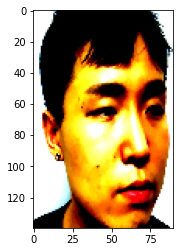

In [72]:
batch_size = 4
num_workers = 4

train_dataset = FaceData(train_img_paths)
test_dataset = FaceData(test_img_paths)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)



print(len(train_img_paths),len(test_img_paths))
t = 0
for i in tqdm(train_loader) :
    t+=i[0].shape[0]
print(t,t==len(train_img_paths))
# t = 0
# for i in tqdm(test_loader) :
#     t+=i[0].shape[0]
# print(t,t==len(test_img_paths))

# data, cloud_data, scaled_cloud, label
print(len(i),i[0].shape,i[1].shape,i[2].shape)
plt.imshow(i[0][0].permute(1,2,0))
plt.show()

<AxesSubplot:>

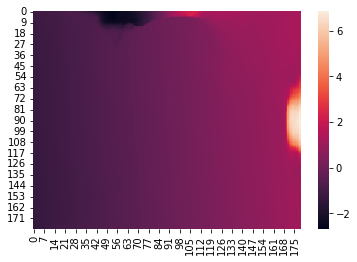

In [73]:
sns.heatmap(i[2][0][2])